# Bayesian linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d
from jax import numpy as jnp, scipy as jscipy
from jax import grad
import scipy.stats


rc('font',size=16)
rc('animation', html='jshtml')

We know the formulation of the simple linear regression for feature matrix $X$ and target vector $\mathbf{y}=[y_1,y_2,..,y_N]^T$,

$$
\mathbf{y} = X\boldsymbol{\theta} + \boldsymbol{\epsilon}
$$

In Bayesian settings, we can define the Linear regression as following,

\begin{align}
p(\boldsymbol{\theta}|X, \mathbf{y}) &= \frac{p(\mathbf{y}|X, \boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y}|X)}\\
\mathcal{N}(\boldsymbol{\theta}|\mathbf{m}_n, S_n) & = \frac{\mathcal{N}(\mathbf{y}|X\boldsymbol{\theta}, \sigma_n^2I)\mathcal{N}(\boldsymbol{\theta}|0, \sigma^2I)}{p(\mathbf{y}|X)}
\end{align}

Where, $\sigma_n^2$ is noise variance and $\sigma^2$ is variance in parameters ($\theta$).

## Bayesian linear regression (1D without bias)

Let's consider this simplest case first. Consider the following dataset with $3$ points.

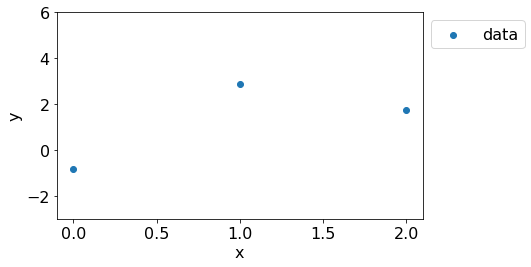

In [2]:
np.random.seed(2)

plt.figure(figsize=(8,4))
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
t = 3
sigma_n = 2
y = t*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.scatter(x, y, label='data');plt.xlabel('x');plt.ylabel('y');
plt.ylim(-3,6);plt.legend(bbox_to_anchor=(1.3,1));
plt.tight_layout()

### MLE for $\theta$

Now, we should be able to appreciate the effectiveness of MLE as we can find such $\theta$ so that our likelihood of observing given data $D=\mathbf{y}$ is maximized.

\begin{align}
p(D|\theta) &= \frac{1}{\sqrt{(2\pi)^N}\sigma_n^N}exp\left[-\sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2}\right] \\
\log p(D|\theta) &= -\frac{N}{2}\log(2\pi\sigma_n^2) - \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2}\\
\arg\min_\theta\;(-\log p(D|\theta))&= \arg\min_\theta \sum\limits_{i=1}^{N}(y_i - \theta x_i)^2\\
\end{align}

This turns out as the same cost function in linear regression.

\begin{align}
\frac{d}{d\theta} \log p(D|\theta) &= \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)x_i}{\sigma_n^2} = 0\\
\theta_{MLE} &= \frac{\sum\limits_{i=1}^{N}y_ix_i}{\sum\limits_{i=1}^{N}x_i^2}
\end{align}

Let us visualize the likelihood pdf for various values of $\theta$ and plot $\theta_{MLE}$.

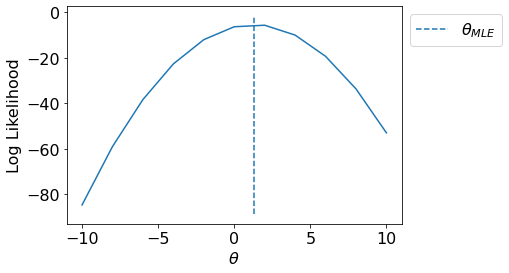

In [3]:
def LogLikelihood(y, x, theta):
    N = x.shape[0]
    return np.log(scipy.stats.multivariate_normal.pdf(y.ravel(), (theta*x).ravel(), np.eye(N)*sigma_n**2))

T = np.linspace(-10,10,11)
LL = [LogLikelihood(y, x, t1) for t1 in T]
fig, ax = plt.subplots()
ax.plot(T, LL);
ax.vlines(np.sum(x*y)/np.sum(np.square(x)),*ax.get_ylim(), linestyle='--', label='$\\theta_{MLE}$')
ax.set_xlabel("$\\theta$");ax.set_ylabel("Log Likelihood");
plt.legend(bbox_to_anchor=[1,1]);

We can visualize the fit resulted by $\theta_{MLE}$ on the dataset.

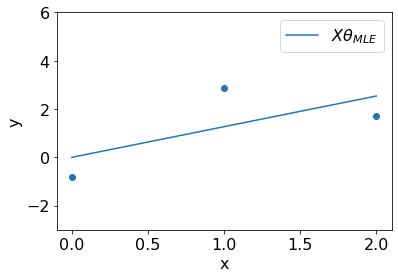

In [4]:
np.random.seed(1)

plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y).squeeze()/np.sum(np.square(x)).squeeze()
plt.plot(x, t_mle*x, label='$X\\theta_{MLE}$');plt.ylim(-3,6);
plt.legend();

Note that we can achive similar fit with gradient descent on negative log likelihood (same as cost function) as illustrated below.

In [5]:
def JLogLikelihood(y, x, theta):
    N = x.shape[0]
    return jnp.log(jscipy.stats.multivariate_normal.pdf(y.ravel(), (theta*x).ravel(), jnp.eye(N)*sigma_n**2))

costs = []
thetas = []
theta = 10.
lr = 0.1

grad_func = grad(JLogLikelihood, argnums=[2])
for iteration in range(20):
    dt = -grad_func(y, x, theta)[0]
    theta = theta - lr*dt
    costs.append(-JLogLikelihood(y, x, theta))
    thetas.append(theta)

rc('font',size=14)
fig, ax = plt.subplots(1,2,figsize=(10,4))
def update(i):
    ax[1].cla();ax[0].cla();
    ax[0].plot(T, -np.array(LL),color='b')
    ax[0].set_xlabel('$\\theta$');ax[0].set_ylabel('Neg Log Likelihood');
    ax[0].scatter(thetas[:i+1], costs[:i+1], label='Solution',c='r')
    ax[0].legend()
    ax[1].scatter(x,y)
    ax[1].plot(x, thetas[i]*x, label='$X\\theta$')
    ax[1].set_xlabel('x');ax[1].set_ylabel('y');
    ax[1].legend()
    ax[1].set_ylim(-5,16);
    plt.tight_layout()

plt.close()
anim = FuncAnimation(fig, update, range(20))
anim

<Figure size 432x288 with 0 Axes>

### MAP for linear regression

We have assumed a Gaussian distribution over $\boldsymbol{\theta}$ because likelihood is Gaussian (conjugate priors).

\begin{align}
p(\boldsymbol{\theta}) \sim \mathcal{N}(0, \sigma^2I)
\end{align}

In [6]:
sigma = 2

Let us draw multiple samples from the prior distribution.

In [7]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
np.random.seed(2)

sample_size = 20

prior_theta = np.linspace(-8,8,200)
samples = np.random.normal(0, sigma, size=sample_size)

rc('font',size=14)
def update(i):
    for axs in ax:
        axs.cla()
    ax[0].plot(prior_theta, scipy.stats.norm.pdf(prior_theta, loc=0, scale=sigma), label='pdf')
    ax[0].set_xlabel('$\\theta$');ax[0].set_ylabel('pdf');
    ax[0].scatter(samples[i], scipy.stats.norm.pdf(samples[i], loc=0, scale=sigma), label='sample')
    ax[0].legend()
    ax[1].scatter(x,y)
    ax[1].plot(x, samples[i]*x, label='$X\\theta$')
    ax[1].set_xlabel('x');ax[1].set_ylabel('y');
    ax[1].legend()
    ax[1].set_ylim(-4,16);
    ax[0].set_xlim(-8,8);
#     plt.tight_layout()
plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(sample_size))
anim

Now, we will find MAP estimate incorporating the prior.

\begin{align}
p(\theta|D) \propto p(D|\theta)p(\theta) &= \frac{1}{\sqrt{(2\pi)^N}\sigma_n^N}exp\left[-\frac{1}{2}(\mathbf{y}-\theta\mathbf{x})^T(I\sigma_n^2)^{-1}(\mathbf{y}-\theta\mathbf{x})\right] \frac{1}{\sqrt{2\pi \sigma^2}}exp\left[{-\frac{(\theta-0)^2}{2\sigma^2}}\right]
\\
\log [p(D|\theta)p(\theta)] &= -\frac{N}{2}\log(2\pi\sigma_n^2) - \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2} - \frac{1}{2}\log(2\pi \sigma^2)-\frac{\theta^2}{2 \sigma^2}\\
\frac{d}{d\theta}\log [p(D|\theta)p(\theta)] &=  \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)x_i}{\sigma_n^2} - \frac{\theta}{\sigma^2} = 0\\
\theta_{MAP} &= \frac{\sum\limits_{i=1}^{N}y_ix_i}{\sum\limits_{i=1}^{N}x_i^2 + \frac{\sigma_n^2}{\sigma^2}}
\end{align}

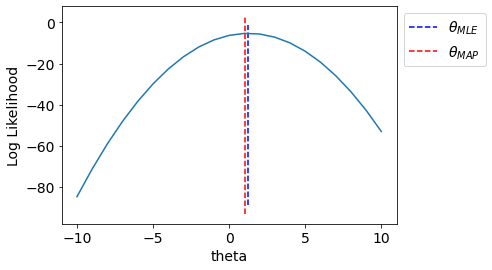

In [8]:
def get_MAP(sigma=sigma, sigma_n=sigma_n):
    return (np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2)))

T = np.linspace(-10,10,21)
LL = [-LogLikelihood(y, x, t1) for t1 in T]
fig, ax = plt.subplots()
ax.plot(T, -np.array(LL));

ax.vlines(np.sum(x*y)/np.sum(np.square(x)),*ax.get_ylim(),linestyle='--',label='$\\theta_{MLE}$',color='b')
ax.vlines(get_MAP(),*ax.get_ylim(),linestyle='--',label='$\\theta_{MAP}$',
          color='r')
ax.set_xlabel("theta");ax.set_ylabel("Log Likelihood");
plt.legend(bbox_to_anchor=[1,1]);

We see that MAP incorporated effect of prior.

Let us see other interesting insights. Following plot shows that higher value of $\sigma$ denotes weak regularization and thus MAP gets closer to MLE if $\sigma$ is too high.

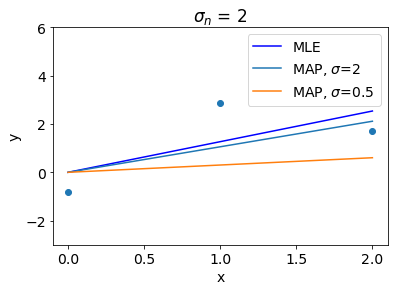

In [9]:
np.random.seed(1)

plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE', color='b')
t_map = get_MAP()
plt.plot(x, t_map*x, label=f'MAP, $\sigma$={sigma}')
t_map = get_MAP(sigma=0.5)
plt.plot(x, t_map*x, label=f'MAP, $\sigma$={0.5}')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'$\sigma_n$ = {sigma_n}');

In contrast to that, Higher value of $\sigma_n$ denotes stronger regularization and thus for high values of $\sigma_n$, MAP gets close to the prior mean.

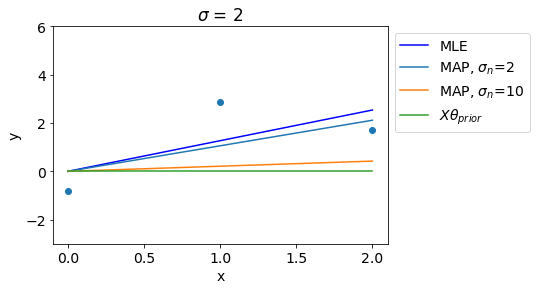

In [10]:
np.random.seed(1)

plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE',color='b')
t_map = get_MAP()
plt.plot(x, t_map*x, label=f'MAP, $\sigma_n$={sigma_n}')
t_map = get_MAP(sigma_n=10)
plt.plot(x, t_map*x, label=f'MAP, $\sigma_n$={10}')
plt.plot(x, x*0, label='$X\\theta_{prior}$')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'$\sigma$ = {sigma}');

## Bayesian linear regression (1D with bias term)

Now, we will programatically explore MLE and MAP for 1D linear regression after including the bias term.

\begin{align}
\mathbf{\theta}_{MLE} &= (X^TX)^{-1}X^T\mathbf{y}\\
\\
\mathbf{\theta}_{MAP} &= (X^TX + I\frac{\sigma_n^2}{\sigma^2})^{-1}X^T\mathbf{y}
\end{align}

Consider a dataset with 3 points as the following,

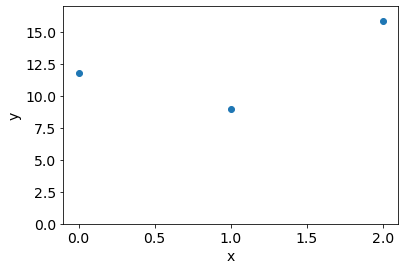

In [11]:
np.random.seed(0)
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
sigma_n = 2

t0, t1 = 3, 4
sigma_n = 5
y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.ylim(0,17)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');

We get MLE and MAP as the following,

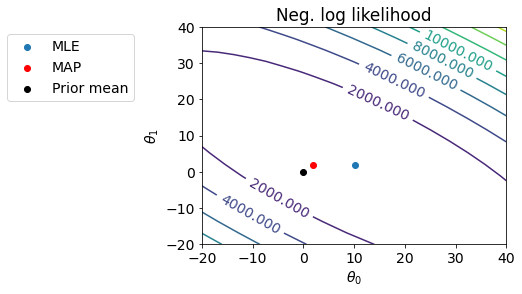

In [12]:
def LogLin2D(t0, t1):
    N = x.shape[0]
    return (N/2)*jnp.log(2*jnp.pi*sigma_n**2) + jnp.sum(jnp.square(y-t0-t1*x))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)

T0, T1 = np.meshgrid(np.linspace(-20,40,20), np.linspace(-20,40,20))
Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
mp = ax.contour(T0, T1, Z, levels=10);
plt.clabel(mp);
ax.set_xlabel('$\\theta_0$');ax.set_ylabel('$\\theta_1$');
ax.set_title('Neg. log likelihood');
x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y
# ax.annotate('GT', (t0, t1))
ax.scatter(t0_mle, t1_mle, label='MLE');
# ax.annotate('MLE', (t0_mle, t1_mle))
ax.scatter(t0_map, t1_map, label='MAP',c='r');
# ax.annotate('MAP', (t0_map, t1_map))
ax.scatter(0, 0, label='Prior mean',c='k');
# ax.text(-4,0, 'Prior mean')
ax.legend(bbox_to_anchor=(-0.2,1));

Let us see the fit with $\theta_{MLE}$ and $\theta_{MAP}$.

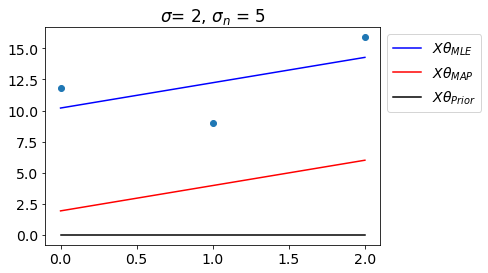

In [13]:
plt.scatter(x,y);
plt.plot(x, t0_mle+t1_mle*x, label='$X\\theta_{MLE}$',color='b')
plt.plot(x, t0_map+t1_map*x, label='$X\\theta_{MAP}$',color='r')
plt.plot(x, 0*x, label='$X\\theta_{Prior}$',color='k')
plt.title(f'$\sigma$= {sigma}, $\sigma_n$ = {sigma_n}')
plt.legend(bbox_to_anchor=(1,1));

The animation below shows how MAP changes as we increase the data points.

In [14]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133, projection='3d')
sigma, sigma_n = 1, 2
def update(N):
    ax.cla();ax1.cla();ax2.cla()
    np.random.seed(1)
    x = np.linspace(0,2,N).reshape(-1,1)
    y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
    x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
    t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
    t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y

    ax.scatter(x,y);
    ax.plot(x, t0_mle+t1_mle*x, label='$X\\theta_{MLE}$',color='b')
    ax.plot(x, t0_map+t1_map*x, label='$X\\theta_{MAP}$',color='r')
    ax.plot(x, 0*x, label='$X\\theta_{Prior}$',color='k')
    ax.set_ylim(-1,15)
    ax.set_title(f'$\sigma$ = {sigma}, $\sigma_n$ = {sigma_n}')
    ax.legend(loc='upper left');
    ax.set_xlabel('x');ax.set_ylabel('y')
    
    T0, T1 = np.meshgrid(np.linspace(-10,10,50), np.linspace(-10,10,50))
    Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
    mp = ax1.contour(T0, T1, Z, levels=15);
    ax.clabel(mp);
    ax1.scatter(t0_mle, t1_mle, label='$\\theta_{MLE}$', c='b',marker='d',s=100);
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax1.scatter(t0_map, t1_map, label='$\\theta_{MAP}$', c='r',marker='*',s=100);
    # ax.annotate('MAP', (t0_map, t1_map))
    ax1.scatter(0, 0, label='$\\theta_{Prior}$',c='k',marker='o',s=100);
    ax1.set_xlabel('$\\theta_0$');ax1.set_ylabel('$\\theta_1$',labelpad=-12);
    ax1.set_title('Neg log likelihood');
    
    ax2.contour3D(T0, T1, Z, levels=40);
    ax2.scatter(t0_mle, t1_mle, label='MLE', c='b');
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax2.scatter(t0_map, t1_map, label='MAP', c='r');
    # ax.annotate('MAP', (t0_map, t1_map))
    ax2.scatter(0, 0, label='Prior mean',c='k');
    ax2.view_init(35, 15-90);
    ax2.set_xlabel('$\\theta_0$');ax2.set_ylabel('$\\theta_1$');
    
    plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(2,21))
anim

<Figure size 432x288 with 0 Axes>

What are the insights here?

* If we have less datapoints, $\theta_{MAP}$ would be close to $\theta_{Prior}$
* As we increase number of informative datapoints, $\theta_{MAP}$ gets closer to $\theta_{MLE}$
* If data is too noisy, $\theta_{MAP}$ would be close to $\theta_{Prior}$ and vice versa.

## Posterior distribution over $\theta$

Posterior over $\theta$ is given as the following,

\begin{align}
p(\boldsymbol{\theta}|X, \mathbf{y}) &\sim \mathcal{N}(\mathbf{m}_n, S_n)\\
\mathbf{m}_n &= \left(X^TX + \frac{\sigma_n^2}{\sigma^2}I\right)X^T\mathbf{y}\\
S_n &= \left(\frac{1}{\sigma^2}I + \frac{X^TX}{\sigma_n^2}\right)^{-1}
\end{align}

Note that $\theta_{MAP}$ is nothing but mean of posterior distribution $p(\theta|\mathbf{y})$.

Consider the following dataset,

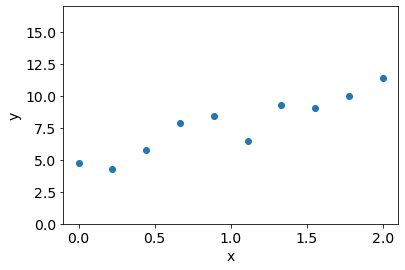

In [15]:
np.random.seed(0)
N = 10
x = np.linspace(0,2,N).reshape(-1,1)
x_extra = np.hstack([np.ones((N, 1)), x])

t0, t1 = 3, 4
sigma_n = 1
sigma = 1

y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.ylim(0,17)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');

Let us visualize prior/posterior distributions.

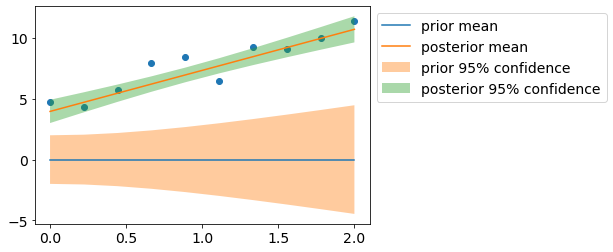

In [16]:
m_0 = np.zeros((2,1))
s_0 = np.eye(2)*sigma**2

m_n = np.linalg.inv(x_extra.T@x_extra + np.eye(2)*(sigma_n**2/sigma**2))@x_extra.T@y
s_n = np.linalg.inv((x_extra.T@x_extra)/sigma_n**2 + np.eye(2)*(1/sigma**2))

y_pr_mean = (x_extra@m_0).squeeze()
y_pr_cov = x_extra@s_0@x_extra.T
y_pr_std2 = np.sqrt(y_pr_cov.diagonal())*2

y_mean = (x_extra@m_n).squeeze()
y_cov = x_extra@s_n@x_extra.T #+ np.eye(N)*sigma_n**2 # uncomment to add likelihood noise
y_std2 = np.sqrt(y_cov.diagonal())*2

plt.scatter(x, y);
plt.plot(x, y_pr_mean, label='prior mean');
plt.fill_between(x_extra[:,1], y_pr_mean-y_pr_std2, y_pr_mean+y_pr_std2, alpha=0.4, label='prior 95% confidence');
plt.plot(x, y_mean, label='posterior mean');
plt.fill_between(x_extra[:,1], y_mean-y_std2, y_mean+y_std2, alpha=0.4, label='posterior 95% confidence');
plt.legend(bbox_to_anchor=(1,1));